In [1]:
import os
import pickle
import time
import numpy as np
import pandas as pd
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns

from sklearn.utils import class_weight
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, recall_score, classification_report
from sklearn.metrics import precision_recall_fscore_support as score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM, Bidirectional
from tensorflow.keras.optimizers import SGD, Adam

from avaml.aggregatedata import ForecastDataset, LabeledData, REG_ENG, CsvMissingError
from utils.preprocess import *
from utils.feature_engineering import *
from utils.nn import *
from utils.plot_nn_training import *

In [2]:
print(tf.__version__)

# we need to set up gpus for tensorflow-gpu and cudnn
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
print(gpus)

tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)

2.2.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
warnings.filterwarnings("ignore")

# Download, read in, preprocess data

In [4]:
model_prefix = ''
days = 7
regobs_types = list(REG_ENG.keys())
labeled_data = None
try:
    print("Reading csv")
    labeled_data = LabeledData.from_csv(days=days, regobs_types=regobs_types, with_varsom=True)
except CsvMissingError:
    print("Csv missing. Fetching online data. (This takes a long time.)")
    labeled_data = ForecastDataset(regobs_types=regobs_types).label(days=days, with_varsom=True)
    labeled_data.to_csv()

Reading csv


In [5]:
# read in data, extract data and labels
labeled_data = preprocess(labeled_data)
regions = labeled_data.data.reorder_levels([1, 0])
labels = labeled_data.label.reorder_levels([1, 0])

One of the first things we need to take care of is the precipitation column. There are some extremely high values throughout the dataset that we need to drop.

In [6]:
precip_cols = [col for col in regions.columns if 'precip' in col and 'exposed' not in col]
regions_precip = regions.loc[:, precip_cols]
regions_precip

,,precip_0,precip_1,precip_2,precip_3,precip_4,precip_5
region,date,,,,,,
3003,2017-12-07,1.0,0.0,0.0,0.0,5.0,2.0
3007,2017-12-07,1.4,6.2,0.0,5.5,12.1,4.3
3009,2017-12-07,1.5,8.0,6.2,5.4,10.6,2.7
3010,2017-12-07,0.1,9.2,12.2,9.0,8.0,2.5
3011,2017-12-07,0.1,9.8,14.2,11.6,8.6,3.0
...,...,...,...,...,...,...,...
3031,2021-01-12,0.0,5.0,10.0,15.0,0.0,0.0
3032,2021-01-12,0.0,0.0,3.0,2.0,0.0,0.0
3034,2021-01-12,0.0,4.0,12.0,10.0,0.0,0.0


There is a set of anomalously high precipitation values in this dataset that we need to be mindful of.

In [7]:
precip_outliers = np.where(regions_precip > 100)[0]
regions_precip.iloc[precip_outliers].head(25)

,,precip_0,precip_1,precip_2,precip_3,precip_4,precip_5
region,date,,,,,,
3006,2020-04-30,6280.500,0.0,0.1,0.3,0.900,1.7
3007,2020-04-30,6280.500,0.0,0.0,0.2,1.300,1.5
3009,2020-04-30,6280.900,0.0,0.0,0.3,1.200,1.6
3010,2020-04-30,6280.500,0.0,0.0,0.2,1.100,2.2
3011,2020-04-30,6280.500,0.0,0.0,0.0,0.700,1.0
3012,2020-04-30,6280.500,0.0,0.0,0.0,0.300,0.7
3013,2020-04-30,6280.858,0.0,0.0,0.1,0.600,1.1
3014,2020-04-30,6280.500,0.0,0.0,0.0,0.200,0.1
3015,2020-04-30,6280.500,0.0,0.0,0.0,0.700,1.1


In [8]:
drop_idx = regions.index[precip_outliers]
regions = regions.drop(drop_idx)
regions

,,danger_level_1,danger_level_2,danger_level_3,danger_level_4,danger_level_5,danger_level_6,emergency_warning_1,emergency_warning_2,emergency_warning_3,emergency_warning_4,...,regobs_snowprofile_t_min_4_4,regobs_snowprofile_t_min_4_5,regobs_snowprofile_t_min_4_6,regobs_snowprofile_t_min_4_7,accuracy_2,accuracy_3,accuracy_4,accuracy_5,accuracy_6,accuracy_7
region,date,,,,,,,,,,,,,,,,,,,,,
3003,2017-12-07,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3007,2017-12-07,3.0,2.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3009,2017-12-07,3.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3010,2017-12-07,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3011,2017-12-07,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3031,2021-01-12,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3032,2021-01-12,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3034,2021-01-12,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
regions.loc[:, precip_cols].max()

precip_0    95.6
precip_1    95.6
precip_2    95.6
precip_3    95.6
precip_4    95.6
precip_5    95.6
dtype: float64

These seem like more reasonable values. We need to do the same thing for the labels, though.

In [10]:
labels = labels.drop(drop_idx)

In [11]:
print('Shape of input data:  {}'.format(regions.shape))
print('Shape of labels    :  {}'.format(labels.shape))

Shape of input data:  (12519, 6516)
Shape of labels    :  (12519, 69)


In [12]:
# encode cause and aspect columns in labels
labels = encode_causes(labels)
labels = encode_aspects(labels)

In a previous Notebook analysis on the importance of different features, we say that different meteorological variables from RegObs are often more important than other fields included in the data. And what's more, combining variables to create custom features is even *more* important. We can create those features again below.

In [13]:
wind_dir_cols = [col for col in regions.columns if 'wind_dir' in col]
# drop wind speed columns
#regions.drop(wind_dir_cols, axis=1, inplace=True)

# create 72 hour sum or max of wind speed, precip, and max temp
wind_speed_cols = [col for col in regions.columns if 'wind' in col and 'speed' in col]
regions = wind_speed_max(regions, wind_speed_cols)
to_sum = ['wind_speed_max_0', 'wind_speed_max_1', 'wind_speed_max_2']
regions = sum_over_features(regions, to_sum, 'wind_speed_72hr')

to_sum = ['precip_0', 'precip_1', 'precip_2']
regions = sum_over_features(regions, to_sum, 'precip_72hr')

to_sum = ['temp_max_0', 'temp_max_1', 'temp_max_2']
regions = take_max(regions, to_sum, 'temp_max_72hr')

We could include all of our important data below with the following code:

```python
dont_include_list = ['acc', 'dir', 'fl_start', 'regobs', 'start']
to_include = [col for col in regions.columns]

for drop_col in dont_include_list:
    to_include = [col for col in to_include if drop_col not in col]

train = regions.loc[:, to_include]
train
```

But a single model works better using just weather data.

In [14]:
dont_include_list = ['acc', 'dir', 'fl_start', 'regobs', 'start']
to_include = [col for col in regions.columns if 'precip' in col or 'temp' in col or 'wind' in col]

for drop_col in dont_include_list:
    to_include = [col for col in to_include if drop_col not in col]
    
train = regions.loc[:, to_include]
train

,,precip_most_exposed_0,precip_most_exposed_1,precip_most_exposed_2,precip_most_exposed_3,precip_most_exposed_4,precip_most_exposed_5,precip_0,precip_1,precip_2,precip_3,...,temp_freeze_lev_5,wind_speed_max_0,wind_speed_max_1,wind_speed_max_2,wind_speed_max_3,wind_speed_max_4,wind_speed_max_5,wind_speed_72hr,precip_72hr,temp_max_72hr
region,date,,,,,,,,,,,,,,,,,,,,,
3003,2017-12-07,8.0,4.0,4.0,8.0,10.0,5.0,1.0,0.0,0.0,0.0,...,0.000,15.5,9.0,9.0,0.0,9.0,9.0,33.5,1.0,-8.0
3007,2017-12-07,1.4,7.5,0.1,6.8,16.0,5.2,1.4,6.2,0.0,5.5,...,237.510,12.0,9.0,5.5,9.0,9.0,12.0,26.5,7.6,-5.9
3009,2017-12-07,1.8,9.0,7.6,6.4,13.0,4.4,1.5,8.0,6.2,5.4,...,267.920,15.5,5.5,9.0,9.0,9.0,9.0,30.0,15.7,-6.5
3010,2017-12-07,0.2,9.7,13.5,10.2,9.2,2.9,0.1,9.2,12.2,9.0,...,326.270,15.5,5.5,12.0,12.0,9.0,9.0,33.0,21.5,-6.2
3011,2017-12-07,0.1,10.3,15.0,13.5,9.5,3.8,0.1,9.8,14.2,11.6,...,210.565,12.0,5.5,5.5,9.0,9.0,9.0,23.0,24.1,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3031,2021-01-12,0.0,10.0,15.0,20.0,2.0,0.0,0.0,5.0,10.0,15.0,...,0.000,9.0,5.5,5.5,15.5,0.0,0.0,20.0,15.0,-5.0
3032,2021-01-12,0.0,2.0,6.0,5.0,0.0,0.0,0.0,0.0,3.0,2.0,...,0.000,12.0,5.5,9.0,12.0,0.0,0.0,26.5,3.0,-9.0
3034,2021-01-12,2.0,8.0,20.0,20.0,0.0,0.0,0.0,4.0,12.0,10.0,...,0.000,9.0,5.5,9.0,12.0,5.5,5.5,23.5,16.0,-7.0


## Scale data

In [15]:
scaled_X = scale_input_data(train.values)
train = pd.DataFrame(scaled_X, columns=train.columns, index=train.index)
train

,,precip_most_exposed_0,precip_most_exposed_1,precip_most_exposed_2,precip_most_exposed_3,precip_most_exposed_4,precip_most_exposed_5,precip_0,precip_1,precip_2,precip_3,...,temp_freeze_lev_5,wind_speed_max_0,wind_speed_max_1,wind_speed_max_2,wind_speed_max_3,wind_speed_max_4,wind_speed_max_5,wind_speed_72hr,precip_72hr,temp_max_72hr
region,date,,,,,,,,,,,,,,,,,,,,,
3003,2017-12-07,0.067170,0.033585,0.033585,0.067170,0.083963,0.041982,0.010460,0.000000,0.000000,0.000000,...,0.000000,0.516667,0.300000,0.300000,0.000000,0.300000,0.300000,0.403614,0.006545,0.371942
3007,2017-12-07,0.011755,0.062972,0.000840,0.057095,0.134341,0.043661,0.014644,0.064854,0.000000,0.057531,...,0.095004,0.400000,0.300000,0.183333,0.300000,0.300000,0.400000,0.319277,0.049744,0.418220
3009,2017-12-07,0.015113,0.075567,0.063812,0.053736,0.109152,0.036944,0.015690,0.083682,0.064854,0.056485,...,0.107168,0.516667,0.183333,0.300000,0.300000,0.300000,0.300000,0.361446,0.102760,0.404998
3010,2017-12-07,0.001679,0.081444,0.113350,0.085642,0.077246,0.024349,0.001046,0.096234,0.127615,0.094142,...,0.130508,0.516667,0.183333,0.400000,0.400000,0.300000,0.300000,0.397590,0.140722,0.411609
3011,2017-12-07,0.000840,0.086482,0.125945,0.113350,0.079765,0.031906,0.001046,0.102510,0.148536,0.121339,...,0.084226,0.400000,0.183333,0.183333,0.300000,0.300000,0.300000,0.277108,0.157740,0.504165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3031,2021-01-12,0.000000,0.083963,0.125945,0.167926,0.016793,0.000000,0.000000,0.052301,0.104603,0.156904,...,0.000000,0.300000,0.183333,0.183333,0.516667,0.000000,0.000000,0.240964,0.098178,0.438054
3032,2021-01-12,0.000000,0.016793,0.050378,0.041982,0.000000,0.000000,0.000000,0.000000,0.031381,0.020921,...,0.000000,0.400000,0.183333,0.300000,0.400000,0.000000,0.000000,0.319277,0.019636,0.349905
3034,2021-01-12,0.016793,0.067170,0.167926,0.167926,0.000000,0.000000,0.000000,0.041841,0.125523,0.104603,...,0.000000,0.300000,0.183333,0.300000,0.400000,0.183333,0.183333,0.283133,0.104724,0.393979


In [16]:
print(np.any(np.isnan(train)))

False


In [17]:
# could use CLASS_danger_level or CLASS_problem_1
train_labels = labels.loc[:, ['CLASS_danger_level']]
train_labels

,,CLASS_danger_level
region,date,
3003,2017-12-07,2
3007,2017-12-07,2
3009,2017-12-07,2
3010,2017-12-07,3
3011,2017-12-07,3
...,...,...
3031,2021-01-12,3
3032,2021-01-12,3
3034,2021-01-12,3


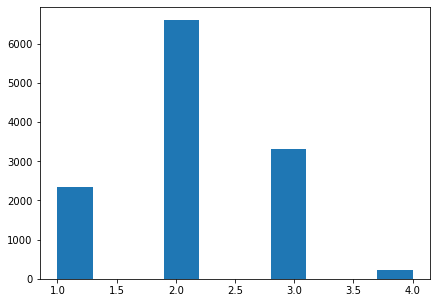

In [18]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.hist(train_labels.values, align='mid',)
plt.show()

So we see that there is a heavy imbalance in the class weights that we are trying to predict. This is not ideal for our case, because more than anything we need to reliably be able to predict danger levels 3 and 4. 

In another Notebook in this directory, we look at outlier detection for only predicting danger level 4's. This works *okay*, but it is hard to tell exactly *how* well because the there is a difference in the way that Scikit-Learn and TensorFlow report metrics. Thus, the performance is largely determined by the random initialization of the neural network's weights.

For this Notebook, we are going to instead combine danger levels 3 and 4 to predict a new class where the danger level is at least danger level 3.

In [19]:
train_labels[train_labels.values == 4] = 3
np.unique(train_labels)

array([1, 2, 3])

Next, we should recode our values from [1, 3] -> [0, 2]. Many metrics require there to be a "0" class present in your labels.

In [20]:
train_labels[train_labels.values == 1] = 0
train_labels[train_labels.values == 2] = 1
train_labels[train_labels.values == 3] = 2
np.unique(train_labels)

array([0, 1, 2])

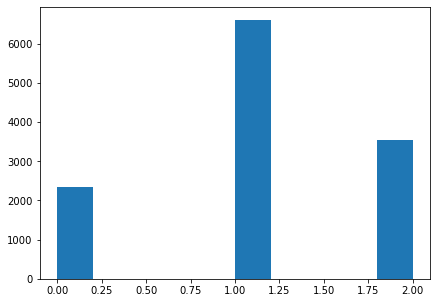

In [21]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.hist(train_labels.values, align='mid',)
plt.show()

In [22]:
class_occurrences = (train_labels.value_counts() / len(train_labels) * 100).sort_index()
round(class_occurrences, 2)

CLASS_danger_level
0                     18.82
1                     52.81
2                     28.37
dtype: float64

Scikit-learn makes it easy to compute class weights for imbalanced classification tasks.

In [24]:
flat_values = [value[0] for value in train_labels.values]
weights = class_weight.compute_class_weight('balanced',
                                            np.unique(flat_values),
                                            flat_values)

print(weights)

[1.77122241 0.63122069 1.17483108]


In [25]:
class_weights = {
    0: 1.75,
    1: 0.64,
    2: 1.15
}

Lastly, we can include the danger level in the input data. When we batch and window the data, this means that we can use danger level from the past week to predict tomorrow's danger level.

In [26]:
train['danger_level'] = train_labels
train

,,precip_most_exposed_0,precip_most_exposed_1,precip_most_exposed_2,precip_most_exposed_3,precip_most_exposed_4,precip_most_exposed_5,precip_0,precip_1,precip_2,precip_3,...,wind_speed_max_0,wind_speed_max_1,wind_speed_max_2,wind_speed_max_3,wind_speed_max_4,wind_speed_max_5,wind_speed_72hr,precip_72hr,temp_max_72hr,danger_level
region,date,,,,,,,,,,,,,,,,,,,,,
3003,2017-12-07,0.067170,0.033585,0.033585,0.067170,0.083963,0.041982,0.010460,0.000000,0.000000,0.000000,...,0.516667,0.300000,0.300000,0.000000,0.300000,0.300000,0.403614,0.006545,0.371942,1
3007,2017-12-07,0.011755,0.062972,0.000840,0.057095,0.134341,0.043661,0.014644,0.064854,0.000000,0.057531,...,0.400000,0.300000,0.183333,0.300000,0.300000,0.400000,0.319277,0.049744,0.418220,1
3009,2017-12-07,0.015113,0.075567,0.063812,0.053736,0.109152,0.036944,0.015690,0.083682,0.064854,0.056485,...,0.516667,0.183333,0.300000,0.300000,0.300000,0.300000,0.361446,0.102760,0.404998,1
3010,2017-12-07,0.001679,0.081444,0.113350,0.085642,0.077246,0.024349,0.001046,0.096234,0.127615,0.094142,...,0.516667,0.183333,0.400000,0.400000,0.300000,0.300000,0.397590,0.140722,0.411609,2
3011,2017-12-07,0.000840,0.086482,0.125945,0.113350,0.079765,0.031906,0.001046,0.102510,0.148536,0.121339,...,0.400000,0.183333,0.183333,0.300000,0.300000,0.300000,0.277108,0.157740,0.504165,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3031,2021-01-12,0.000000,0.083963,0.125945,0.167926,0.016793,0.000000,0.000000,0.052301,0.104603,0.156904,...,0.300000,0.183333,0.183333,0.516667,0.000000,0.000000,0.240964,0.098178,0.438054,2
3032,2021-01-12,0.000000,0.016793,0.050378,0.041982,0.000000,0.000000,0.000000,0.000000,0.031381,0.020921,...,0.400000,0.183333,0.300000,0.400000,0.000000,0.000000,0.319277,0.019636,0.349905,2
3034,2021-01-12,0.016793,0.067170,0.167926,0.167926,0.000000,0.000000,0.000000,0.041841,0.125523,0.104603,...,0.300000,0.183333,0.300000,0.400000,0.183333,0.183333,0.283133,0.104724,0.393979,2


# Split data

In [27]:
train_idx = [3007, 3012, 3010, 3009, 3013, 3017, 3014, 3032, 
             3027, 3029, 3022, 3031, 3023, 3037, 3024, 3028]
val_idx =   [3011, 3016, 3035]
test_idx =  [3006, 3015, 3034]

X_train = [train.loc[idx].values for idx in train_idx]
y_train = [train_labels.loc[idx].values for idx in train_idx]

X_val = [train.loc[idx].values for idx in val_idx]
y_val = [train_labels.loc[idx].values for idx in val_idx]

X_test = [train.loc[idx].values for idx in test_idx]
y_test = [train_labels.loc[idx].values for idx in test_idx]

In [28]:
print(len(train_idx), len(X_train), len(y_train))
print(len(val_idx), len(X_val), len(y_val))
print(len(test_idx), len(X_test), len(y_test))

16 16 16
3 3 3
3 3 3


In [29]:
sequence_length = 14 # this is an arbitrary choice, a hyperparameter
X_train_pad = [pad_sequence(arr, sequence_length) for arr in X_train]
y_train_pad = [pad_sequence(arr, sequence_length) for arr in y_train]

X_val_pad = [pad_sequence(arr, sequence_length) for arr in X_val]
y_val_pad = [pad_sequence(arr, sequence_length) for arr in y_val]

X_test_pad = [pad_sequence(arr, sequence_length) for arr in X_test]
y_test_pad = [pad_sequence(arr, sequence_length) for arr in y_test]

In [30]:
for (arr, label) in zip(X_train_pad, y_train_pad):
    print(arr.shape, label.shape)

(574, 58) (574, 1)
(574, 58) (574, 1)
(574, 58) (574, 1)
(574, 58) (574, 1)
(574, 58) (574, 1)
(574, 58) (574, 1)
(574, 58) (574, 1)
(574, 58) (574, 1)
(574, 58) (574, 1)
(574, 58) (574, 1)
(574, 58) (574, 1)
(574, 58) (574, 1)
(574, 58) (574, 1)
(336, 58) (336, 1)
(574, 58) (574, 1)
(574, 58) (574, 1)


### Creating a windowed dataset
- https://curiousily.com/posts/time-series-forecasting-with-lstms-using-tensorflow-2-and-keras-in-python/
- https://stackoverflow.com/questions/45435049/lstm-understand-timesteps-samples-and-features-and-especially-the-use-in-resha
- https://stackoverflow.com/questions/48491737/understanding-keras-lstms-role-of-batch-size-and-statefulness

Instead of jumping by `sequence_length` below, we need to shift by a certain amount every time. So use days 1-7 to predict day 8, days 2-8 to predict day 9, etc.

Then the labels should start by predicting day 8, 9, etc.

In [31]:
# reshape data into (samples, timesteps, features)
X_concat_train = np.concatenate(X_train_pad)
y_concat_train = np.concatenate(y_train_pad)

X_concat_val = np.concatenate(X_val_pad)
y_concat_val = np.concatenate(y_val_pad)

X_concat_test = np.concatenate(X_test_pad)
y_concat_test = np.concatenate(y_test_pad)

print(X_concat_train.shape)
print(y_concat_train.shape)
print(X_concat_val.shape)
print(y_concat_val.shape)
print(X_concat_test.shape)
print(y_concat_test.shape)

(8946, 58)
(8946, 1)
(1722, 58)
(1722, 1)
(1316, 58)
(1316, 1)


In order to use the recall metric, you need to have your vector of binary values one-hot encoded as a 2D matrix. We can do that below.

In [32]:
encoder = OneHotEncoder()
y_concat_train = encoder.fit_transform(y_concat_train).toarray()
y_concat_val = encoder.fit_transform(y_concat_val).toarray()
y_concat_test = encoder.fit_transform(y_concat_test).toarray()

In [33]:
batchX_train, batchY_train = batch_data(X_concat_train, y_concat_train, sequence_length)
batchX_val, batchY_val = batch_data(X_concat_val, y_concat_val, sequence_length)
batchX_test, batchY_test = batch_data(X_concat_test, y_concat_test, sequence_length)

(8932, 14, 58) (8932, 3)
(1708, 14, 58) (1708, 3)
(1302, 14, 58) (1302, 3)


# Training a neural network

## DNN
We can define our neural network below. This is a multiclass classification problem, meaning that we need as many output units in the last layer as there are unique labels in our training set. It also means that we should use a softmax activation in the last layer and some form of categorical crossentropy as the loss function.

In [36]:
# network params
input_neurons = 100
output_neurons = len(np.unique(y_concat_train)) + 1 # length two array has three elements
drop = 0.3

# training params
num_epochs = 400
alpha = 1e-4
batch_size = 256
criterion = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr=alpha)

In [37]:
window_dnn = create_dnn(batchX_train, input_neurons, drop, output_neurons)

window_dnn_history = train_multiclass(window_dnn, batchX_train, batchY_train, 
                           batchX_val, batchY_val, criterion, optimizer, 
                           batch_size, num_epochs, class_weights)

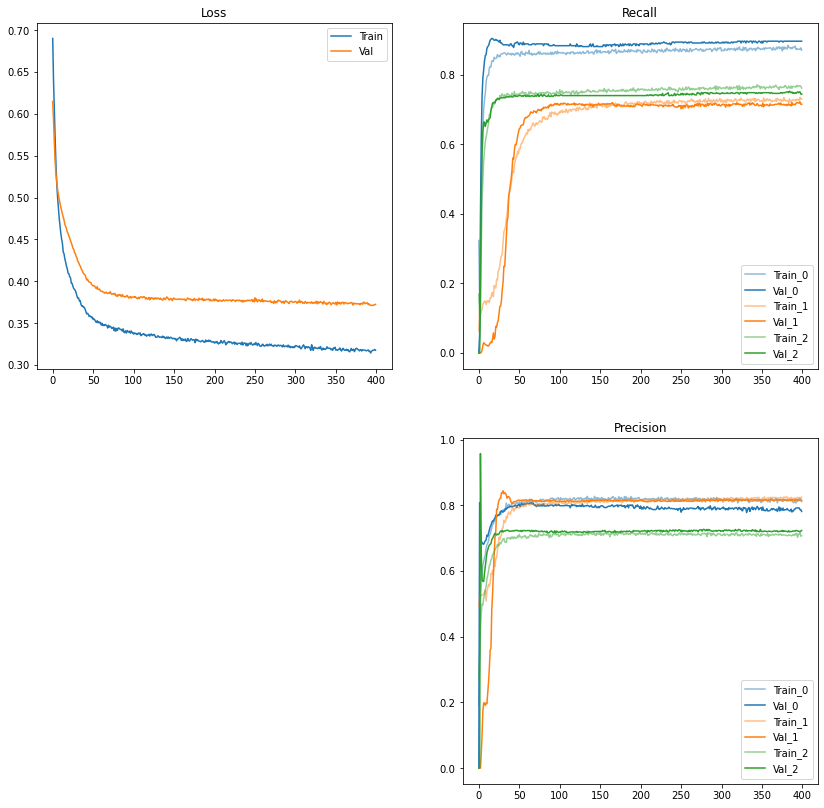

In [38]:
plot_history_multiclass(window_dnn_history.history)

precision: [0.79262673 0.80462725 0.71572581]
recall:    [0.89119171 0.73733804 0.75052854]
fscore:    [0.83902439 0.76951444 0.73271414]


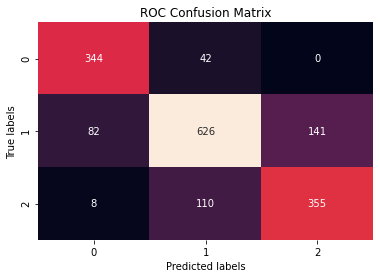

In [39]:
preds = plot_confusion_matrix(window_dnn, batchX_val, np.argmax(batchY_val, axis=1))

We are close to overfitting, and the recall curves look much stagnant for the validation set. And now with regularization?

In [40]:
window_dnn_reg = create_dnn(batchX_train, input_neurons, drop, output_neurons, True)

window_dnn_reg_history = train_multiclass(window_dnn_reg, batchX_train, batchY_train, 
                               batchX_val, batchY_val, criterion, optimizer, 
                               batch_size, num_epochs, class_weights)

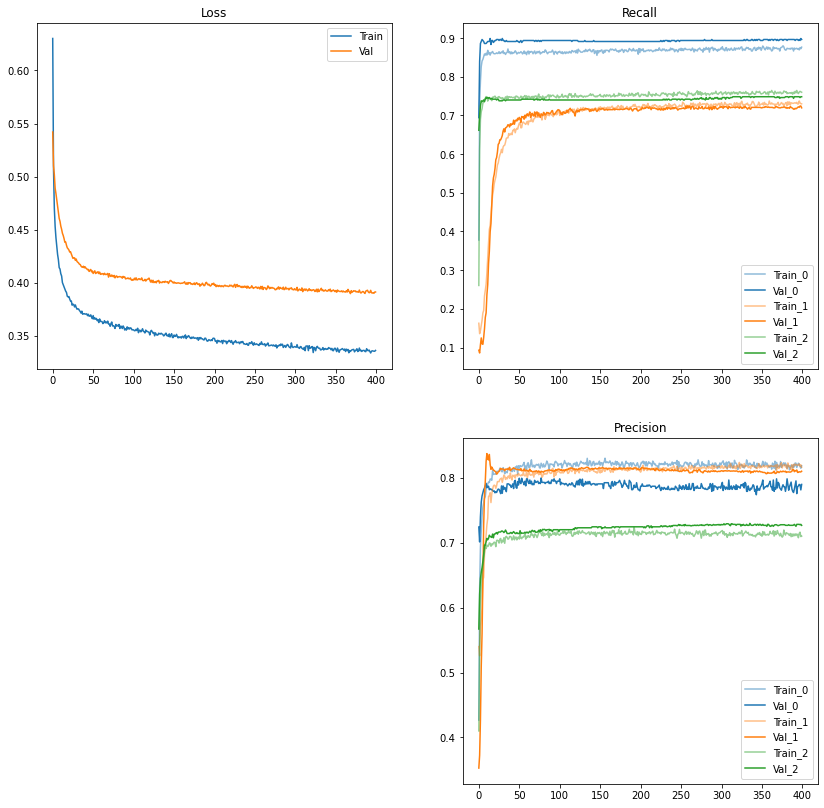

In [41]:
plot_history_multiclass(window_dnn_reg_history.history)

precision: [0.79357798 0.80694981 0.71717172]
recall:    [0.89637306 0.7385159  0.75052854]
fscore:    [0.84184915 0.77121771 0.73347107]


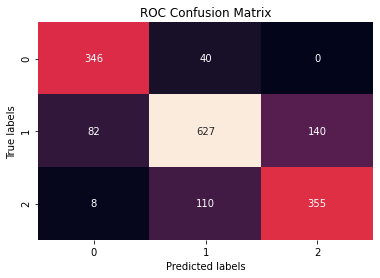

In [42]:
preds = plot_confusion_matrix(window_dnn_reg, batchX_val, np.argmax(batchY_val, axis=1))

**DNN Summary**: In general, networks with L2 regularization in the dense layers performed the same. The windowed dataset worked better than day of data (not shown). However, we are close to overfitting, so I don't think we can improve performance without decreasing the learning rate. We could also try reducing the number of neurons in each layer and increasing the number of layers.

###  LSTM
We can repeat the same steps as above, but this time with a LSTM to see how that affects performance.

In [43]:
# network params
input_neurons = 8
dense_neurons = 10
drop = 0.3

# training params
num_epochs = 200
alpha = 1e-5
batch_size = 128

In [44]:
window_rnn = create_rnn(batchX_train, input_neurons, dense_neurons, drop, output_neurons)

window_rnn_history = train_multiclass(window_rnn, batchX_train, batchY_train, 
                           batchX_val, batchY_val, criterion, optimizer, 
                           batch_size, num_epochs, class_weights)

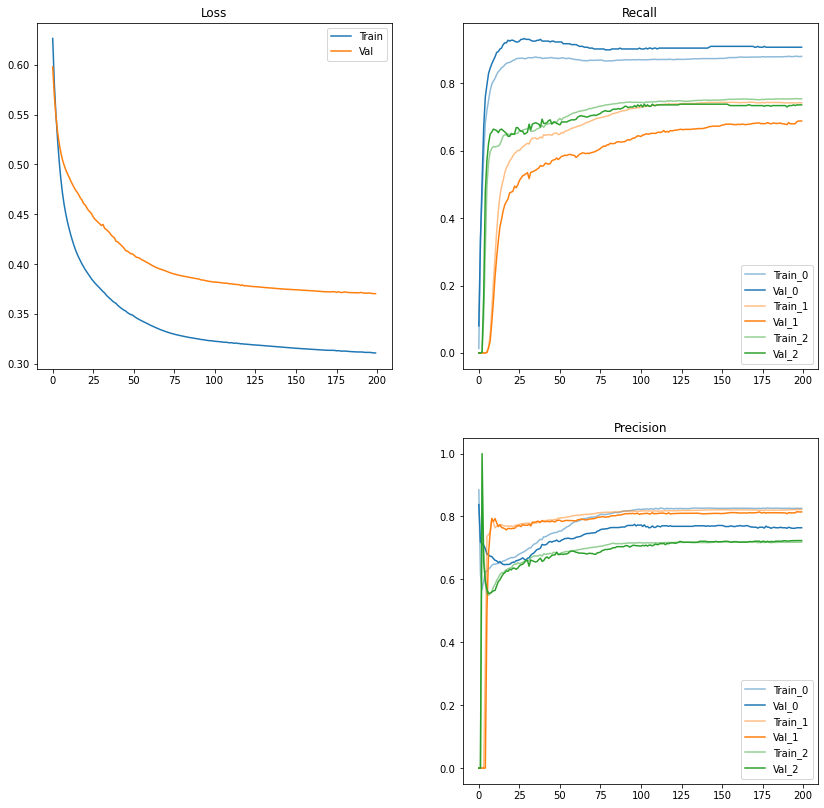

In [45]:
plot_history_multiclass(window_rnn_history.history)

precision: [0.75319149 0.80718085 0.72222222]
recall:    [0.91709845 0.71495878 0.74207188]
fscore:    [0.8271028  0.75827608 0.73201251]


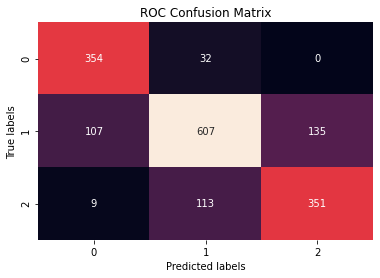

In [46]:
preds = plot_confusion_matrix(window_rnn, batchX_val, np.argmax(batchY_val, axis=1))

The loss curves actually look pretty good, but again the recall and precision curves stagnate and look worse than for the DNN case. What about if we add regularization?

In [47]:
window_rnn_reg = create_rnn(batchX_train, input_neurons, dense_neurons, drop, output_neurons, True)

window_rnn_reg_history = train_multiclass(window_rnn_reg, batchX_train, batchY_train, 
                               batchX_val, batchY_val, criterion, optimizer, 
                               batch_size, num_epochs, class_weights)

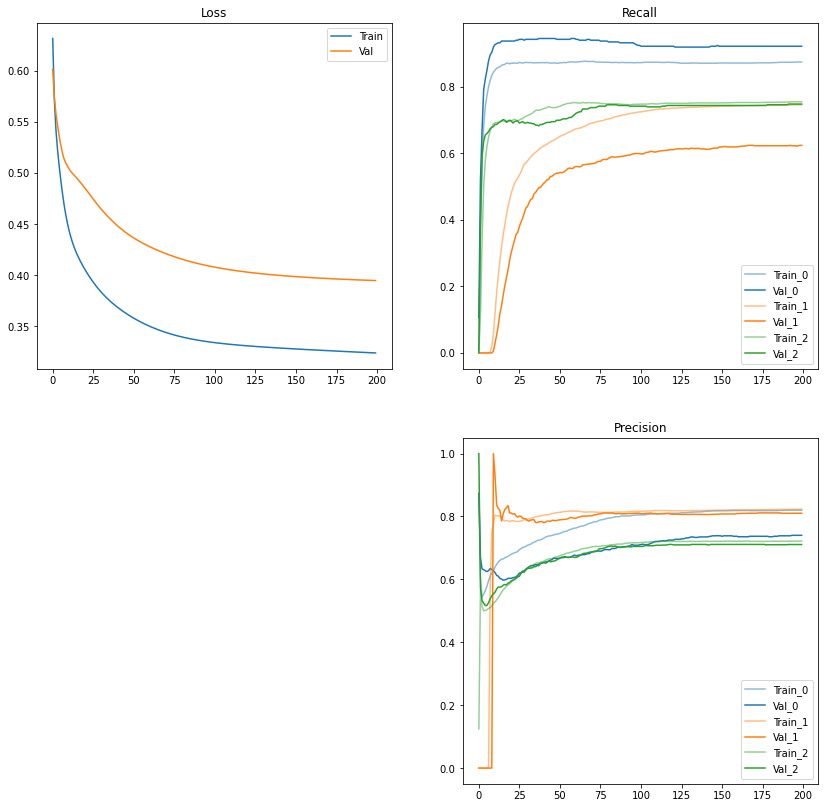

In [48]:
plot_history_multiclass(window_rnn_reg_history.history)

precision: [0.70058708 0.80952381 0.70436508]
recall:    [0.92746114 0.66077739 0.75052854]
fscore:    [0.79821628 0.72762646 0.72671443]


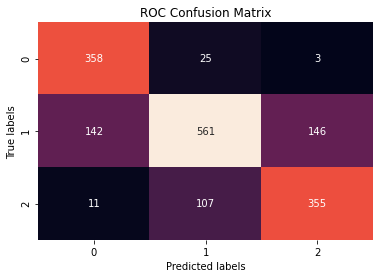

In [49]:
preds = plot_confusion_matrix(window_rnn_reg, batchX_val, np.argmax(batchY_val, axis=1))

**RNN Summary**: Not better with regularization.

# Summary
So neither a single DNN or RNN model could tell many of the danger levels apart with recall and precision > 75%. This is not great, we'd ideally like to be in the > 90% range, at least for recall. What we could do is train a separate neural network on each danger level (1, 2, 3+4).

Also, training a single model works better when using less data (just weather data instead of all the data we have).

# Predicting on the test set

This is relatively easy to set up. Since we have already processed the test set alongside the training and validation sets, it should be ready to go.

The best model so far was the DNN without regularization. We should save this model so that we can load it later (instead of running the whole Notebook again). Note: we only need to save the model once unless we decide to retrain the model later.

In [ ]:
# save best model
# https://www.tensorflow.org/tutorials/keras/save_and_load?hl=en
# best_dnn = window_dnn_reg
# best_rnn = window_rnn_reg

# best_dnn.save('models/dnn_dl_123')
# best_rnn.save('models/rnn_dl_123')

In [ ]:
# # load saved model
# best_dnn = tf.keras.models.load_model('models/model_dl_123')
# test_preds = plot_confusion_matrix(best_dnn, batchX_test, np.argmax(batchY_test, axis=1))

In [ ]:
# best_rnn = tf.keras.models.load_model('models/rnn_dl_123')
# test_preds = plot_confusion_matrix(best_rnn, batchX_test, np.argmax(batchY_test, axis=1))